# Imports and constants

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from classifiers.utils.feature_extractors import ColorHistogramTransformer, HuMomentsTransformer, \
    HaralickFeaturesTransformer

from classifiers.utils.load_balanced_data import load_balanced_data_pipeline

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
import joblib

from sklearn.preprocessing import label_binarize


# Load and preprocess data

In [21]:
metadata_path = "HAM10000_metadata.csv"
image_dir = "HAM10000_images_part_1"

augmented_images, augmented_labels = load_balanced_data_pipeline(metadata_path, image_dir)

Loading balanced data...
Metadata loaded.
Generating image ID list...
Image ID list generated.
Loading images for augmentation...
Augmenting images...
Images augmented.
Data loading complete.


# Train/test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

# Feature extraction

In [23]:
feature_union = FeatureUnion([
    ("color_histogram", ColorHistogramTransformer()),
    ("hu_moments", HuMomentsTransformer()),
    ("haralick_features", HaralickFeaturesTransformer())
])

# Ensemble classifier pipeline
## Load the models

In [24]:
rf = joblib.load("models/random_forest.pkl")
knn = joblib.load("models/knn_classifier.pkl")
svm = joblib.load("models/svm_classifier.pkl")

## Prepare ensemble classifier (both soft and hard voting)

In [25]:
soft_ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('knn', knn),
    ('svm', svm),
], voting='soft')

hard_ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('knn', knn),
    ('svm', svm),
], voting='hard')

# Train and predict

In [26]:
soft_ensemble.fit(X_train, y_train_1d)
hard_ensemble.fit(X_train, y_train_1d)

soft_ensemble_preds = soft_ensemble.predict(X_test)
hard_ensemble_preds = hard_ensemble.predict(X_test)

# Classification report

In [27]:
# Evaluate the ensemble classifiers
print("Soft voting ensemble Classification Report:")
print(classification_report(y_test_1d, soft_ensemble_preds))
print("Accuracy:", accuracy_score(y_test_1d, soft_ensemble_preds))

print("Hard voting ensemble Classification Report:")
print(classification_report(y_test_1d, hard_ensemble_preds))
print("Accuracy:", accuracy_score(y_test_1d, hard_ensemble_preds))


Soft voting ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79        32
           1       0.67      0.78      0.72        40
           2       0.72      0.74      0.73        35
           3       0.72      0.62      0.67        42
           4       0.84      0.74      0.79        43
           5       0.97      0.93      0.95        42
           6       0.98      0.96      0.97        46

    accuracy                           0.81       280
   macro avg       0.80      0.81      0.80       280
weighted avg       0.81      0.81      0.81       280

Accuracy: 0.8071428571428572
Hard voting ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.88      0.70        32
           1       0.67      0.75      0.71        40
           2       0.76      0.74      0.75        35
           3       0.81      0.62      0.70        42
           4   

# Confusion matrix

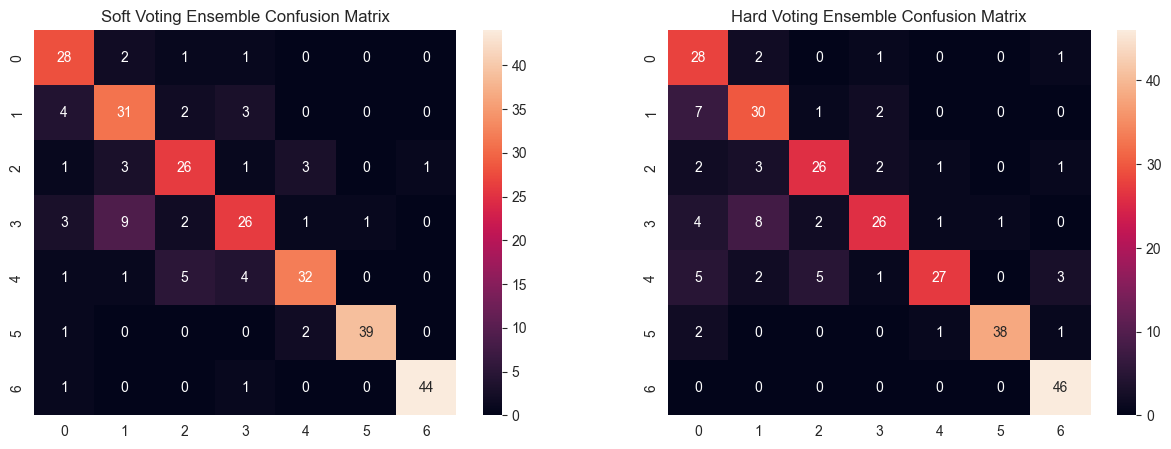

In [28]:
# Compute confusion matrices
cm_soft = confusion_matrix(y_test_1d, soft_ensemble_preds)
cm_hard = confusion_matrix(y_test_1d, hard_ensemble_preds)

# Plot the confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(cm_soft, annot=True, fmt="d", ax=ax[0])
ax[0].set_title("Soft Voting Ensemble Confusion Matrix")
sns.heatmap(cm_hard, annot=True, fmt="d", ax=ax[1])
ax[1].set_title("Hard Voting Ensemble Confusion Matrix")
plt.show()

# ROC curve and AUC

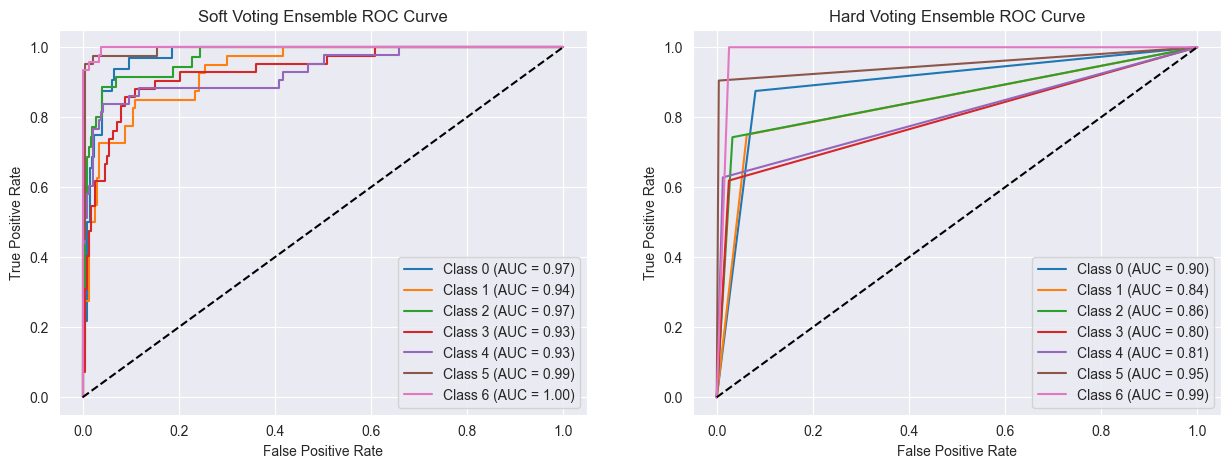

In [29]:
# Predict probabilities for soft voting
y_score_soft = soft_ensemble.predict_proba(X_test)

# Predict labels for hard voting (use predict instead of predict_proba)
y_pred_hard = hard_ensemble.predict(X_test)
y_score_hard = label_binarize(y_pred_hard, classes=[0, 1, 2, 3, 4, 5, 6])

# Calculate ROC curves and AUC for each class
fpr_soft = {}
tpr_soft = {}
roc_auc_soft = {}

fpr_hard = {}
tpr_hard = {}
roc_auc_hard = {}

for i in range(y_train.shape[1]):
    fpr_soft[i], tpr_soft[i], _ = roc_curve(y_test[:, i], y_score_soft[:, i])
    roc_auc_soft[i] = roc_auc_score(y_test[:, i], y_score_soft[:, i])

    fpr_hard[i], tpr_hard[i], _ = roc_curve(y_test[:, i], y_score_hard[:, i])
    roc_auc_hard[i] = roc_auc_score(y_test[:, i], y_score_hard[:, i])

for i in range(y_train.shape[1]):
    fpr_soft[i], tpr_soft[i], _ = roc_curve(y_test[:, i], y_score_soft[:, i])
    roc_auc_soft[i] = roc_auc_score(y_test[:, i], y_score_soft[:, i])

    fpr_hard[i], tpr_hard[i], _ = roc_curve(y_test[:, i], y_score_hard[:, i])
    roc_auc_hard[i] = roc_auc_score(y_test[:, i], y_score_hard[:, i])

# Plot the ROC curves for each class
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(y_train.shape[1]):
    ax[0].plot(fpr_soft[i], tpr_soft[i], label=f"Class {i} (AUC = {roc_auc_soft[i]:.2f})")
    ax[1].plot(fpr_hard[i], tpr_hard[i], label=f"Class {i} (AUC = {roc_auc_hard[i]:.2f})")
ax[0].set_title("Soft Voting Ensemble ROC Curve")
ax[1].set_title("Hard Voting Ensemble ROC Curve")
for i in range(2):
    ax[i].plot([0, 1], [0, 1], color='black', linestyle='--')
    ax[i].set_xlabel("False Positive Rate")
    ax[i].set_ylabel("True Positive Rate")
    ax[i].legend()
plt.show()

# Precision-recall curve

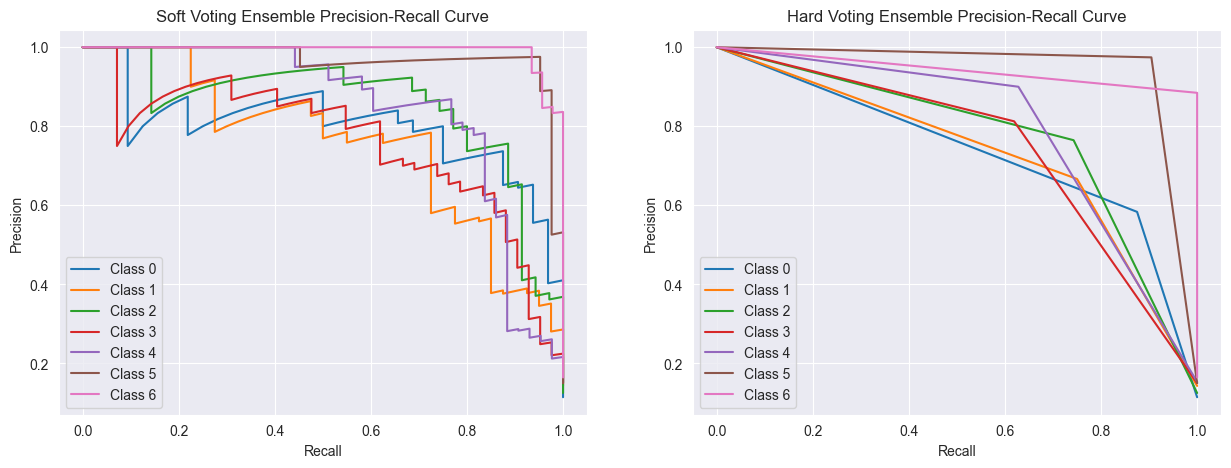

In [30]:
precision_soft = {}
recall_soft = {}

precision_hard = {}
recall_hard = {}

for i in range(y_train.shape[1]):
    precision_soft[i], recall_soft[i], _ = precision_recall_curve(y_test[:, i], y_score_soft[:, i])
    precision_hard[i], recall_hard[i], _ = precision_recall_curve(y_test[:, i], y_score_hard[:, i])

# Plot the precision-recall curves for each class
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(y_train.shape[1]):
    ax[0].plot(recall_soft[i], precision_soft[i], label=f"Class {i}")
    ax[1].plot(recall_hard[i], precision_hard[i], label=f"Class {i}")
ax[0].set_title("Soft Voting Ensemble Precision-Recall Curve")
ax[1].set_title("Hard Voting Ensemble Precision-Recall Curve")
for i in range(2):
    ax[i].set_xlabel("Recall")
    ax[i].set_ylabel("Precision")
    ax[i].legend()
plt.show()

# Save the model

In [31]:
joblif_file_soft = "models/soft_voting_classifier.pkl"
joblib_file_hard = "models/hard_voting_classifier.pkl"

joblib.dump(soft_ensemble, joblif_file_soft)
joblib.dump(hard_ensemble, joblib_file_hard)

['models/hard_voting_classifier.pkl']